<b> Lovely Lanthanides </b>
<p>
<i> Some fun, mash-together coding to help practice Python concepts and create a nice reference plot for the lanthanide states relevant for upconversion, downconversion, and quantum cutting. </i>
<p>
Note: To run this, you will need to install the following packages: 

In [11]:
import lxml.html as lh
import pandas as pd
import html2text
import re
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from wavelength_color import wavelength_to_rgb

Let's grab the text file we'll be using to grab all of the cool information about our 10 lanthanides. Please note that this file was extracted from source code of the following publication:

This publication created a lovely and incredibly useful table with all of this information. We're going to parse that data out of the webpages html code, store it, and then plot it in an updateable figure.

In [12]:
file = open("PrincipleLanthanideTransitions.txt","r", encoding="utf-8")
doc = file.readlines()

First we'll extract the header information, which can be found at the beginning of the file. 

In [13]:
headers = []
h = html2text.HTML2Text()
# Ignore converting links from HTML
h.ignore_links = True
for line in doc[11:19]:
    actual_text = h.handle(line)
    actual_text = actual_text.strip()
    actual_text = actual_text.strip("|")
    actual_text = actual_text.strip()
    headers.append(actual_text)
print(headers)

['Ln', 'Ground state', 'Excited state', 'Final state', 'Emission wavelength (nm)', 'Energy (cm−1)', 'Intensity', 'Remarks']


Next, we'll look at the rest of this text file and remove all of the html muck we don't care about. <i>If you uncomment the last two lines of the next cell, you can see what our text file looks like now (in list form) and how many total entries we have (298).</i>

In [14]:
info = []
for line in doc[23:]:
    actual_text = h.handle(line)
    actual_text = actual_text.strip()
    actual_text = actual_text.strip("|")
    actual_text = actual_text.replace("![\\[thin space\n\\(1/6-em\\)\\]](https://www.rsc.org/images/entities/char_2009.gif)","")
    actual_text = actual_text.replace("![\\[thin\nspace \\(1/6-em\\)\\]](https://www.rsc.org/images/entities/char_2009.gif)","")
    actual_text = actual_text.strip()
    if actual_text != "":
        info.append(actual_text)
#print(info)
#print(len(info))

Now let's do some parsing. This is just picking out patterns in our list of strings (e.g. is there an arrow in the string? does this look like an element symbol?). Following these patterns, we'll store information in a nested dictionary (dictionaries within a dictionary). 
<p>
The upper level dicitionary will have the lanthanide element symbols (e.g. 'Pr', 'Yb', etc.) as keys and a dictionary as a value. This lower level dictionary will have keys following the headings of our original table (e.g. 'Transition', 'Remarks', etc.), and values matching those keys for each transition.

In [15]:
i = 0

lanthanides = {}
while i < len(info):
    #Check for element symbol
    if info[i][0].isupper() and info[i][1].islower() and len(info[i]) == 2:
        #Grab that element!
        current_lanthanide = info[i]
        lanthanides[current_lanthanide] = {'Transition': [], headers[4]: [], headers[5]: [], headers[6]: [], headers[7]: []}
        i += 1
        
        #Grab that ground state!
        ground_state = info[i]
        i += 1
        
    if "→" in info[i]:
        #Grab that excited state!
        excited_state = info[i]
        i += 1
    
        #Grab that final state!
        final_state = info[i]
        
        transition = excited_state + ' ' + final_state
        lanthanides[current_lanthanide]['Transition'].append(transition)
        lanthanides[current_lanthanide]['Emission wavelength (nm)'].append(info[i+1])
        lanthanides[current_lanthanide]['Energy (cm−1)'].append(info[i+2])
        lanthanides[current_lanthanide]['Intensity'].append(info[i+3])
        lanthanides[current_lanthanide]['Remarks'].append(info[i+4])
        i += 5
            
    else:
        #Grab that final state!
        final_state = info[i]
        
        transition = excited_state + ' ' + final_state
        lanthanides[current_lanthanide]['Transition'].append(transition)
        lanthanides[current_lanthanide]['Emission wavelength (nm)'].append(info[i+1])
        lanthanides[current_lanthanide]['Energy (cm−1)'].append(info[i+2])
        lanthanides[current_lanthanide]['Intensity'].append(info[i+3])
        lanthanides[current_lanthanide]['Remarks'].append(info[i+4])
        
        i += 5

Really quick we're going to copy these dictionaries into dataframes, which can be useful for looking at this data in a tabulated way (and also just fun for us to explore dataframes and dictionaries). Here we're displaying the transitions, their respective emission wavelengths, and their remarks, but note that you can choose which columns of the dataframe you want to show.

In [16]:
df = {}
for key in lanthanides:
    print(key)
    df[key] = pd.DataFrame(lanthanides[key])
    print(df[key][['Transition', 'Emission wavelength (nm)','Remarks']])

Pr
  Transition Emission wavelength (nm)    Remarks
0  3P2 → 3H4                      440         QC
1  3P1 → 3H4                      470         QC
2  3P1 → 1G4                      872         QC
3  3P0 → 3H4                      480  UC and QC
4  3P0 → 3H5                      545  UC and QC
5  3P0 → 3H6                      606  UC and QC
6  3P0 → 3F2                      640  UC and QC
7  1D2 → 3F4                     1037         QC
Nd
       Transition Emission wavelength (nm)    Remarks
0   4D3/2 → 4I9/2                      355  UC and QC
1   2P3/2 → 4I9/2                      380  UC and QC
2  2P3/2 → 4I11/2                      410  UC and QC
3  2P3/2 → 4I13/2                      452  UC and QC
4   4G7/2 → 4I9/2                      545  UC and QC
5  4G7/2 → 4I11/2                      587  UC and QC
6  4G7/2 → 4I13/2                      655  UC and QC
7   4F3/2 → 4I9/2                      886  QC and DS
8  4F3/2 → 4I11/2                     1064  QC and DS
9  4F3/2 → 4I

In the next cell, we'll build a widget. For now we want something that gives us some interactability for selecting specific transitions we want to look at and allows us to select multiple transitions at once. Note that widgets with the same description value are linked, so changes to one widget will automatically affect the same widget somewhere else. This is useful for us, as we can create the widget here but use it later in our code.
<p>
    <i>You can look at what this widget displays as by uncommenting the last line.</i>

In [24]:
#Let's make some widgets!
widget_list = []
for key in lanthanides:
    #This will be a multi-select list of the transitions for that lanthanide.
    widget_info = widgets.SelectMultiple(
        options=[lanthanides[key]['Transition'][i] for i in range(len(lanthanides[key]['Transition']))],
        value=[],
        description='Transitions',
        disabled=False
    )
    #This will be the Select All Checkbox if we care about all of the transitions.
    lanthanide_select_all = widgets.Checkbox(
    value=False,
    description= key + ' Select All',
    disabled=False
    )
    container = widgets.HBox(children=[lanthanide_select_all,widget_info])
    widget_list.append(container)

tab_contents = [key for key in lanthanides]
children = widget_list
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, tab_contents[i])
#tab

Next we need to write a function that we can call to grab and update the transitions that have been selected in our widget. The function will take no inputs but will provide two outputs: a list of wavelengths and a list of "intensity" values. Here, we're calling an intensity of 'Weak' as equal to 1, 'Medium' as 3, and 'Strong' as 5. This is just for plotting purposes, so we can show relatively the intensity of the emission.

In [18]:
def update():
#If any 'select all' boxes are checked, update the tab view to reflect that then
#Grab list of selected states so that these can eventually be plotted
    box_ticks = [tab.children[k].children[0].value for k in range(len(tab_contents))]
    if any(box_ticks):
        for j in range(len(box_ticks)):
            if box_ticks[j]:
                tab.children[j].children[1].value = tab.children[j].children[1].options
    #Let's clear what we plotted previously so that we can update via appending
    lanthanide_x = []
    lanthanide_y = []
    #Look through all of those lanthanides!
    for z in range(len(tab_contents)):
        #Look through all of those transitions!
        for transition in children[z].children[1].value:
            element_data = df[tab_contents[z]]
            #Match the selected transitions with the tabulated data, so that we can grab that data (wavelength and intensity)
            if transition in element_data['Transition'].values:
                transition_index = element_data[element_data['Transition'] == transition].index.values
                intensity = element_data['Intensity'][transition_index].values
                #Grab intensity information
                if intensity == 'Strong':
                    intensity_value = 5
                elif intensity == 'Weak':
                    intensity_value = 1
                else:
                    intensity_value = 3
                #Grab wavelength information
                wavelength = element_data['Emission wavelength (nm)'][transition_index].values[0]
                if '-' in wavelength:
                    wavelength_start = int(wavelength.split('-')[0])
                    lanthanide_x.append(wavelength_start)
                    lanthanide_y.append(intensity_value)
                    wavelength_end = int(wavelength.split('-')[1])
                    lanthanide_x.append(wavelength_end)
                    lanthanide_y.append(intensity_value)
                elif '–' in wavelength:
                    wavelength_start = int(wavelength.split('–')[0])
                    lanthanide_x.append(wavelength_start)
                    lanthanide_y.append(intensity_value)
                    wavelength_end = int(wavelength.split('–')[1])
                    lanthanide_x.append(wavelength_end)
                    lanthanide_y.append(intensity_value)
                else:
                    wavelength = int(wavelength)
                    lanthanide_x.append(wavelength)
                    lanthanide_y.append(intensity_value)
    return lanthanide_x, lanthanide_y

Finally, let's create a plot and pull up our widget. Every time this cell is run, the plot will update based on the selected transitions.

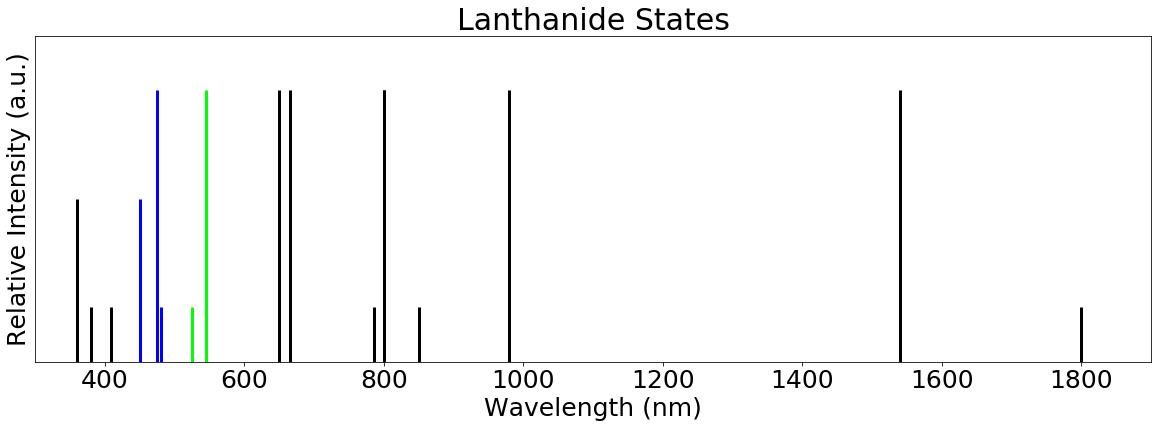

In [26]:
fig = plt.figure(figsize=(20, 6))
#creating a subplot 
ax1 = fig.add_subplot(1,1,1)
ax1.axis([300, 1900, 0, 6])
plt.yticks([])
ax1.set(xlabel='Wavelength (nm)', ylabel='Relative Intensity (a.u.)',
       title='Lanthanide States')
plt.rcParams.update({'font.size': 25})
x_values, y_values = update()
for k in range(len(x_values)):
    ax1.vlines(x = x_values[k], ymin = 0, ymax = y_values[k], colors = wavelength_to_rgb(x_values[k]), linewidths = 3)
plt.show()
tab

In [20]:
wavelength_to_rgb(646)

(0, 0, 0)